In [1]:
from gmm_denoiser import GMMDenoiser
from regularized_denoisers import denoise_l2
from skimage.restoration import denoise_wavelet
from utils import awgn, calc_snr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_excel("data/PD data.xlsx")

In [3]:
train_signals = [
    np.array(df["s1sensor1"]),
    np.array(df["s1sensor2"]),
    np.array(df["s1sensor3"]),
    np.array(df["s1sensor4"]),
    np.array(df["s1sensor5"]),
]

In [4]:
denoiser = GMMDenoiser(gmm_n_components=10, patch_size=30, train_signals=train_signals)
denoiser.fit()

In [5]:
test_signals = [
    np.array(df["s2sensor1"]),
    np.array(df["s2sensor2"]),
    np.array(df["s2sensor3"]),
    np.array(df["s2sensor4"]),
    np.array(df["s2sensor5"]),
]

In [6]:
import importlib
import gmm_denoiser

In [7]:
importlib.reload(gmm_denoiser)

<module 'gmm_denoiser' from 'e:\\Python Projects\\denoising\\gmm_denoiser.py'>

In [8]:
recoverer = gmm_denoiser.GMMRecoverer(gmm_n_components=10, patch_size=30, train_signals=train_signals)
recoverer.fit()

-10


KeyboardInterrupt: 

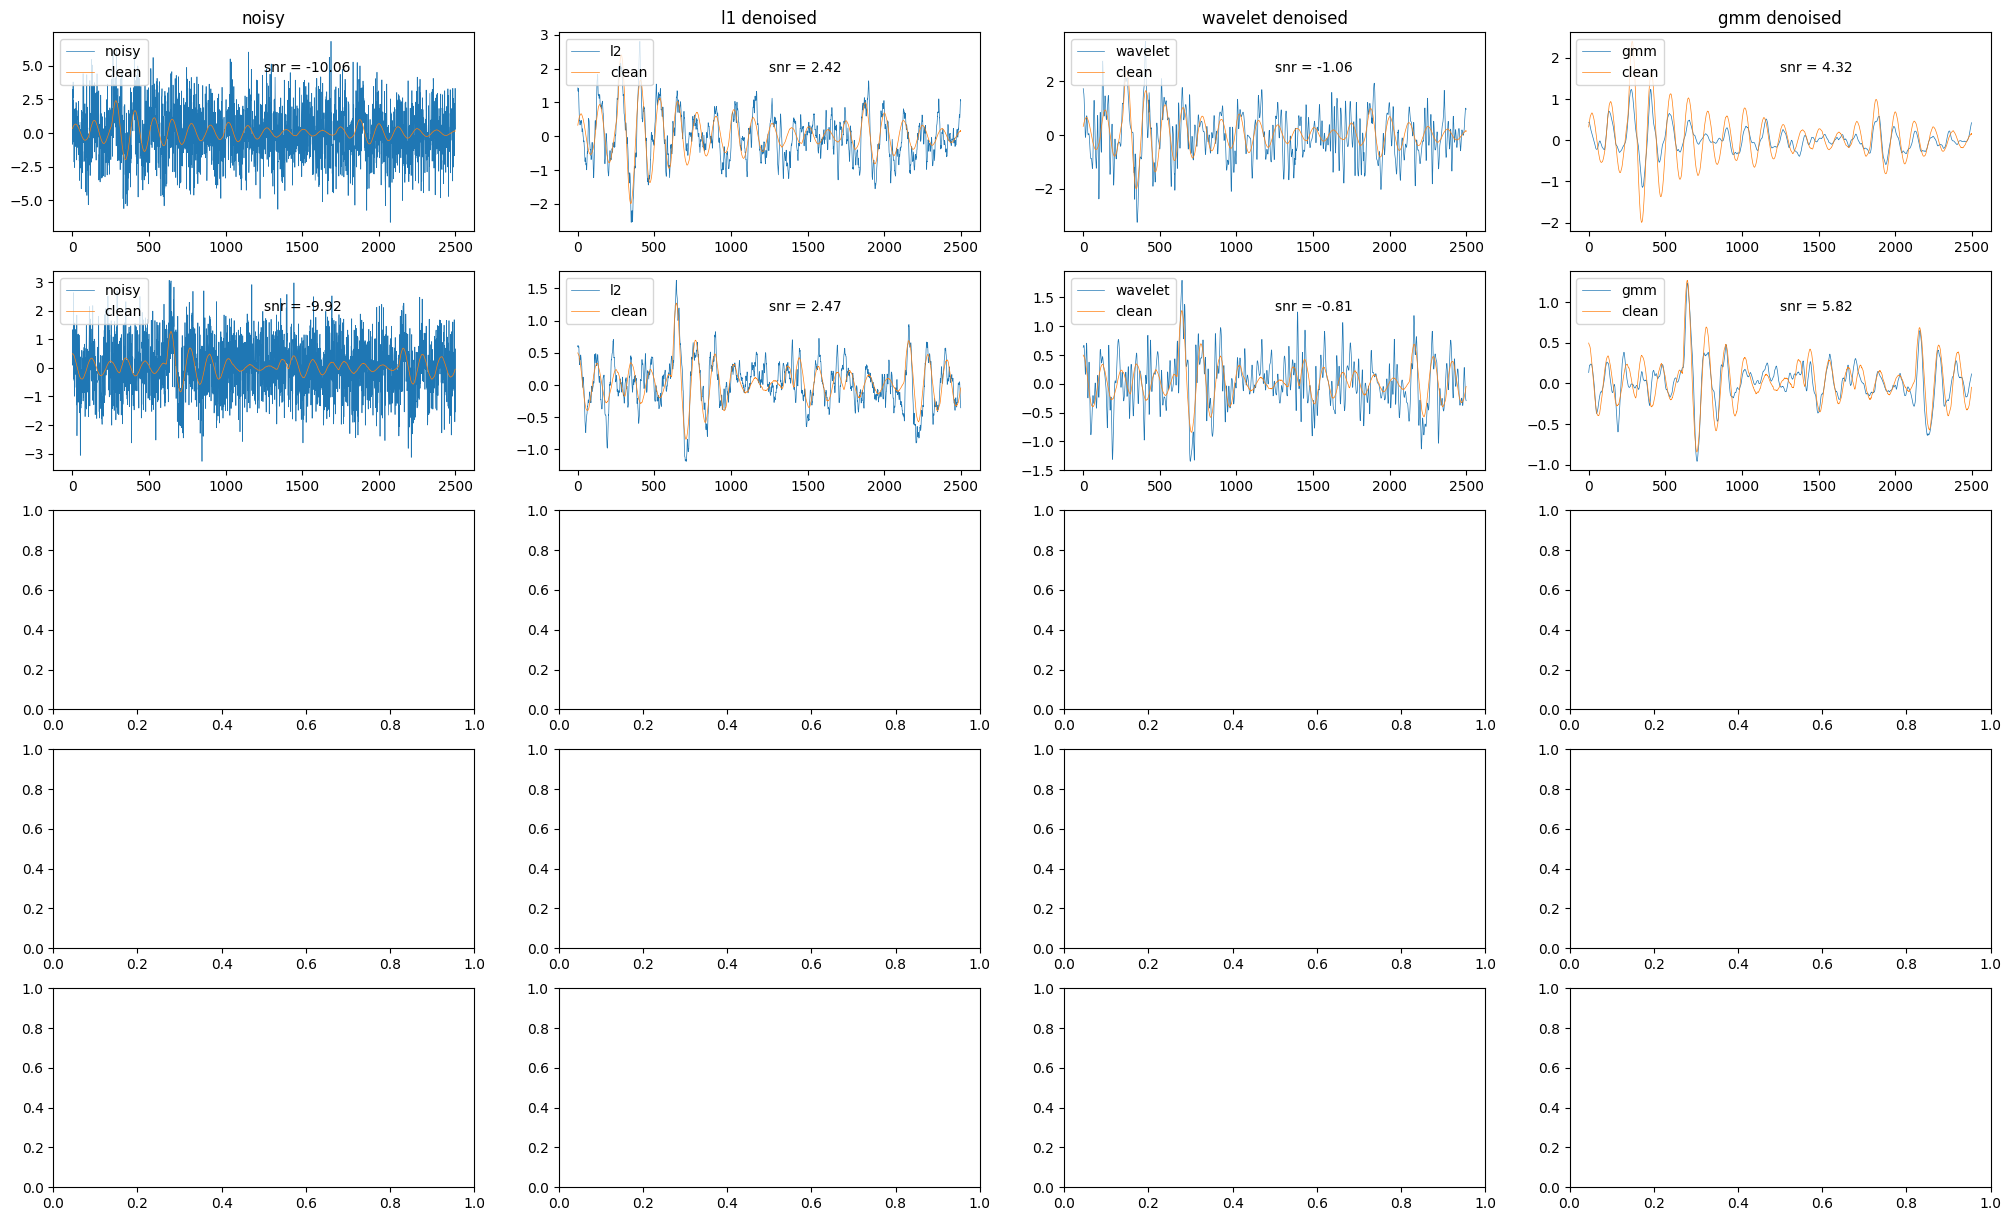

In [9]:
for snr_db in (-10, -5, 0, 5, 10):
    print(snr_db)
    fig, axs = plt.subplots(len(test_signals), 4, figsize=(25, 15))
    axs[0, 0].set_title("noisy")
    axs[0, 1].set_title("l1 denoised")
    axs[0, 2].set_title("wavelet denoised")
    axs[0, 3].set_title("gmm denoised")
    for i, nf in enumerate(test_signals):
        ns = awgn(nf, snr_db)
        nf_w_pred = denoise_wavelet(
            ns,
            method="BayesShrink",
            mode="soft",
            wavelet_levels=3,
            wavelet="sym8",
            rescale_sigma="True",
        )
        nf_l2_pred = denoise_l2(ns, K=20)
        nf_g_pred = denoiser.denoise(ns, snr_db_est=snr_db)

        ax1, ax2, ax3, ax4 = axs[i]

        ax1.plot(ns, linewidth=0.5, label="noisy")
        ax1.plot(nf, linewidth=0.5, label="clean")
        ax1.text(0.5, 0.8, f"snr = {calc_snr(nf, ns):.2f}", transform=ax1.transAxes)
        ax1.legend(loc="upper left")

        ax2.plot(nf_l2_pred, linewidth=0.5, label="l2")
        ax2.plot(nf, linewidth=0.5, label="clean")
        ax2.text(
            0.5, 0.8, f"snr = {calc_snr(nf, nf_l2_pred):.2f}", transform=ax2.transAxes
        )
        ax2.legend(loc="upper left")

        ax3.plot(nf_w_pred, linewidth=0.5, label="wavelet")
        ax3.plot(nf, linewidth=0.5, label="clean")
        ax3.text(
            0.5, 0.8, f"snr = {calc_snr(nf, nf_w_pred):.2f}", transform=ax3.transAxes
        )
        ax3.legend(loc="upper left")

        ax4.plot(nf_g_pred, linewidth=0.5, label="gmm")
        ax4.plot(nf, linewidth=0.5, label="clean")
        ax4.text(
            0.5, 0.8, f"snr = {calc_snr(nf, nf_g_pred):.2f}", transform=ax4.transAxes
        )
        ax4.legend(loc="upper left")

    fig.savefig(f"out/pd_out/lwg,s2,{snr_db}db.png")

In [10]:
for snr_db in (-10, -5, 0, 5, 10):
    print(snr_db)
    for i, nf in enumerate(test_signals):
        ns = awgn(nf, snr_db)
        nf_w_pred = denoise_wavelet(
            ns,
            method="BayesShrink",
            mode="soft",
            wavelet_levels=3,
            wavelet="sym8",
            rescale_sigma="True",
        )
        nf_l2_pred = denoise_l2(ns, K=20)
        nf_g_pred = denoiser.denoise(ns, snr_db_est=snr_db)

        ax1, ax2, ax3, ax4 = axs[i]

        ax1.plot(ns, linewidth=0.5, label="noisy")
        ax1.plot(nf, linewidth=0.5, label="clean")
        ax1.text(0.5, 0.8, f"snr = {calc_snr(nf, ns):.2f}", transform=ax1.transAxes)
        ax1.legend(loc="upper left")

        ax2.plot(nf_l2_pred, linewidth=0.5, label="l2")
        ax2.plot(nf, linewidth=0.5, label="clean")
        ax2.text(
            0.5, 0.8, f"snr = {calc_snr(nf, nf_l2_pred):.2f}", transform=ax2.transAxes
        )
        ax2.legend(loc="upper left")

        ax3.plot(nf_w_pred, linewidth=0.5, label="wavelet")
        ax3.plot(nf, linewidth=0.5, label="clean")
        ax3.text(
            0.5, 0.8, f"snr = {calc_snr(nf, nf_w_pred):.2f}", transform=ax3.transAxes
        )
        ax3.legend(loc="upper left")

        ax4.plot(nf_g_pred, linewidth=0.5, label="gmm")
        ax4.plot(nf, linewidth=0.5, label="clean")
        ax4.text(
            0.5, 0.8, f"snr = {calc_snr(nf, nf_g_pred):.2f}", transform=ax4.transAxes
        )
        ax4.legend(loc="upper left")

    fig.savefig(f"out/pd_out/lwg,s2,{snr_db}db.png")

-10


KeyboardInterrupt: 

In [11]:
test_snrs = [-10, -5, 0, 5, 10]
denoisers = ["none", "wavelet", "gmm"]
results = np.zeros((len(test_signals), len(test_snrs), len(denoisers), len(test_signals[0])))

In [12]:
for i, nf in enumerate(test_signals):
    for j, snr in enumerate(test_snrs):
        print(i, j)
        ns = awgn(nf, snr)
        results[i, j, 0, :] = ns
        results[i, j, 1, :] = denoise_wavelet(ns, method="BayesShrink", mode="soft", wavelet_levels=3, wavelet="sym8", rescale_sigma="True")
        results[i, j, 2, :] = denoiser.denoise(ns, snr_db_est=snr_db)


0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


In [13]:
from utils import *

In [14]:
def ssim(clean, noisy):
    return skimage.metrics.structural_similarity(clean, noisy, data_range=clean.max() - clean.min())

In [15]:
# print(f"{'signal':<8}|{'snr':<8}|{'none':<8}|{'wavelet':<8}|{'gmm':<8}")
print(f"{'method':^15}|{'snr':^8}|{'psnr':^8}|{'mse':^8}|{'ssim':^8}|{'tv':^8}")
csv_s = f"{'method':^15}|{'snr':^8}|{'psnr':^8}|{'mse':^8}|{'ssim':^8}|{'tv':^8}".replace("|",",").replace(" ", "")
for i, nf in enumerate(test_signals):
    for j, snr in enumerate(test_snrs):
        ns = results[i, j, 0]
        for name, dns in zip(denoisers, results[i, j]):
            print(f"{name:<15}|{calc_snr(nf, dns):>8.2f}|{psnr(nf, dns):>8.2f}|{mse(nf, dns):>8.4f}|{ssim(nf, dns):>8.4f}|{tv(dns):>8.1f}")
            csv_s += f"\n{name:<15}|{calc_snr(nf, dns):>8.2f}|{psnr(nf, dns):>8.2f}|{mse(nf, dns):>8.4f}|{ssim(nf, dns):>8.4f}|{tv(dns):>8.1f}".replace("|",",").replace(" ", "")


    method     |  snr   |  psnr  |  mse   |  ssim  |   tv   
none           |  -10.09|    2.16|  3.5077|  0.0029|  5303.5
wavelet        |   -1.20|   11.06|  0.4525|  0.1266|   314.4
gmm            |    4.08|   16.34|  0.1343|  0.4440|    33.2
none           |   -4.92|    7.34|  1.0661|  0.0149|  2931.0
wavelet        |    3.92|   16.18|  0.1392|  0.3152|   191.1
gmm            |    8.49|   20.75|  0.0486|  0.6443|    41.3
none           |    0.15|   12.41|  0.3319|  0.0621|  1573.2
wavelet        |    8.46|   20.72|  0.0489|  0.5090|   127.1
gmm            |   11.92|   24.18|  0.0221|  0.7623|    45.6
none           |    4.88|   17.14|  0.1115|  0.1724|   932.4
wavelet        |   13.91|   26.17|  0.0140|  0.7503|    75.5
gmm            |   14.31|   26.57|  0.0127|  0.8597|    45.2
none           |   10.11|   22.37|  0.0334|  0.4067|   520.1
wavelet        |   19.41|   31.67|  0.0039|  0.9048|    60.4
gmm            |   16.69|   28.95|  0.0074|  0.9361|    46.1
none           |   -9.89

In [28]:
plt.ioff
for i, nf in enumerate(test_signals):
    for j, snr in enumerate(test_snrs):
        print(i, j)
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
        axs[0].set_title("Noisy")
        axs[1].set_title("Wavelet Denoised")
        axs[2].set_title("GMM Denoised")
        for k, dns in enumerate(results[i, j]):
            axs[k].plot(dns, linewidth=0.5, label=("noisy" if k == 0 else "denoised"))
            axs[k].plot(nf, linewidth=0.5, label="clean")
            axs[k].text(0.5, 0.8, f"snr = {calc_snr(nf, dns):.2f}", transform=axs[k].transAxes)
            axs[k].legend(loc="lower right")
        fig.savefig(f"out/pd_out/persigsnr/sig{i}snr{snr}.png")


0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
4 0
4 1
4 2
4 3
4 4


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)